# Урок 7. Классификация с помощью KNN. Кластеризация K-means

#### Подключаем библиотеки

In [25]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import defaultdict

from sklearn.datasets import make_blobs
import random

### Глобальные функции

In [2]:
# Используем евклидову метрику. Реализуем функцию для ее подсчета.

def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

In [24]:
# Функция для построения графиков распределения классов

def get_graph(X, y, k):
    count_classes = len(np.unique(y))
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn(X, y, np.c_[xx.ravel(), yy.ravel()], k)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"Количество классов: {count_classes}. Для kNN классификация при k = {k}")
    plt.show()

In [4]:
# Функция для алгоритма поиска k ближайших соседей. 

def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Сразу рассчитываем вес соседа и сохраняем его
            test_distances.append((distance, y_train[i], 1/(distance + 1)))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            # наибольший вклад вносит сосед на наименьшей дистанции
            classes[d[1]] += d[2]
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [5]:
# Функция для вычисления точности

def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [30]:
# Функция для построения графики коллекции
def get_graph_collections(X, y):
    cmap = ListedColormap(['red', 'green', 'blue'])
    plt.figure(figsize=(7, 7))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

In [60]:
# Функция для определения расстояния от объекта до каждого центроида

def mean_squ_metrics(x1, x2):
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    return np.mean(distance)

In [61]:
# Функция для алгоритма поиска k ближайших соседей.

def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [mean_squ_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
            mean_distance = np.mean(min(distances))
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes, mean_distance

## 1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

In [62]:
# Загрузим один из "игрушечных" датасетов из sklearn.

X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)

X = X[:, :2]

In [63]:
# Разделим выборку на обучающую и тестовую

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

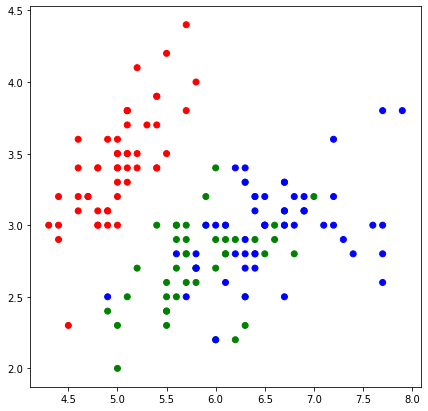

In [64]:
get_graph_collections(X, y)

In [65]:
k = 5
y_pred = knn(X_train, y_train, X_test, k)
print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 5: 0.867


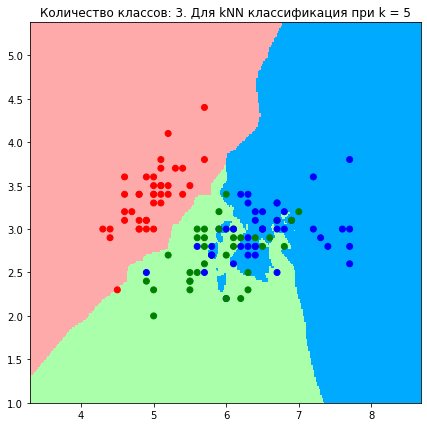

In [66]:
get_graph(X_train, y_train, k)

## 2. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [67]:
X, y = make_blobs(n_samples=100, random_state=1)

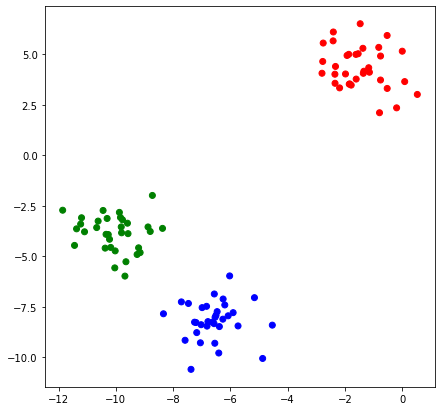

In [68]:
get_graph_collections(X, y)

In [69]:
max_iterations = 5
min_distance = 1e-4
mean_aqu_dist = []

In [70]:
mean_aqu_dist = []
for k in range(1, 11):
    centroids, clusters, mean_distance = kmeans(X, k, max_iterations, min_distance)
    mean_aqu_dist.append(mean_distance)

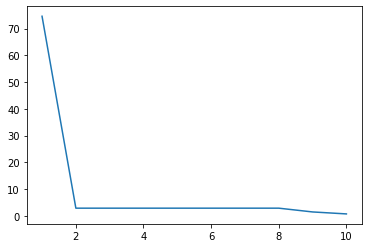

In [71]:
plt.plot(range(1, 11), mean_aqu_dist)